```python
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np

# -----------------------------
# 설정
# -----------------------------
img_height = 32       # 셀 이미지 높이
img_width = 128       # 셀 이미지 폭
num_channels = 1      # 흑백 이미지
max_text_length = 10  # 한 셀 최대 글자 길이
characters = "0123456789DST"  # 인식할 문자 집합
num_classes = len(characters) + 1  # CTC용 blank 문자 추가

# 문자 → 인덱스
char_to_num = tf.keras.layers.StringLookup(vocabulary=list(characters), oov_token="")
num_to_char = tf.keras.layers.StringLookup(vocabulary=list(characters), oov_token="", invert=True)

# -----------------------------
# CNN + BiLSTM + CTC 모델
# -----------------------------
def build_model():
    input_img = layers.Input(shape=(img_height, img_width, num_channels), name='image')

    # CNN feature extractor
    x = layers.Conv2D(64, (3,3), padding='same', activation='relu')(input_img)
    x = layers.MaxPooling2D((2,2))(x)
    x = layers.Conv2D(128, (3,3), padding='same', activation='relu')(x)
    x = layers.MaxPooling2D((2,2))(x)
    
    # CNN 출력 → 시퀀스 변환
    new_shape = ((img_width // 4), (img_height // 4) * 128)
    x = layers.Reshape(target_shape=new_shape)(x)
    x = layers.Dense(64, activation='relu')(x)
    
    # BiLSTM
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True))(x)
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True))(x)
    
    # Output layer
    output = layers.Dense(num_classes, activation='softmax', name='output')(x)
    
    model = models.Model(inputs=input_img, outputs=output)
    return model

# -----------------------------
# CTC Loss 계산용 레이어
# -----------------------------
class CTCLossLayer(layers.Layer):
    def call(self, y_true, y_pred):
        batch_len = tf.cast(tf.shape(y_true)[0], dtype='int64')
        input_length = tf.cast(tf.shape(y_pred)[1], dtype='int64')
        label_length = tf.cast(tf.shape(y_true)[1], dtype='int64')

        input_length = input_length * tf.ones(shape=(batch_len,1), dtype='int64')
        label_length = label_length * tf.ones(shape=(batch_len,1), dtype='int64')

        loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)
        return y_pred

# -----------------------------
# 모델 컴파일
# -----------------------------
base_model = build_model()
labels = layers.Input(name='label', shape=(max_text_length,), dtype='float32')

output = CTCLossLayer()(labels, base_model.output)
model = models.Model(inputs=[base_model.input, labels], outputs=output)

model.compile(optimizer='adam')
model.summary()

# -----------------------------
# 데이터 준비 예시
# -----------------------------
# X: (num_samples, img_height, img_width, 1)
# y: (num_samples, max_text_length) 정수 인덱스
# 실제 학습 시에는 셀 이미지를 crop해서 resize 후 char_to_num으로 변환

# X_dummy = np.random.rand(32, img_height, img_width, 1).astype(np.float32)
# y_dummy = np.random.randint(0, num_classes, size=(32, max_text_length))

# model.fit([X_dummy, y_dummy], y_dummy, epochs=10, batch_size=8)


```python
from pandas import CategoricalDtype, read_csv, DataFrame
import pandas as pd
from math import floor, log10
from pathlib import Path
from tensorflow.data import Dataset, AUTOTUNE
from tensorflow.image import decode_png, resize
from tensorflow.io import read_file
import tensorflow as tf
from matplotlib.pyplot import figure, axis, imshow, show
from tensorflow.keras.backend import clear_session
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping

_1 = 'DEFEAT', 'DRAW', 'VICTORY'
_2 = {'TEAM': 'uint8', 'ROLE': CategoricalDtype(('ALL', 'TANK', 'DAMAGE', 'SUPPORT', 'NONE')), 'E': 'uint8', 'A': 'uint8',
      'D': 'uint8', 'DMG': 'uint16', 'H': 'uint16', 'MIT': 'uint16'}
_3 = (('TANK', 1), ('DAMAGE', 2), ('SUPPORT', 2))
_4 = 1, 2
_5 = [_6 for _6 in _2 if _6 not in {'TEAM', 'ROLE'}]
_7 = pd.concat((pd.read_csv(f'ROLE/{_8}.csv', index_col=0, dtype=_2) for _8 in _1), keys=_1, names=('RESULT',))
_7.dropna(inplace=True)


def _9(_10):
    _11 = {_12: [] for _12 in _2}
    for _13 in _4:
        _14 = _10[_10['TEAM'] == _13]
        for _15, _16 in _3:
            for _17 in range(_16 - sum(_14['ROLE'] == _15)):
                _11['TEAM'].append(_13)
                _11['ROLE'].append(_15)
                for _18 in _5:
                    _11[_18].append(0)
    return DataFrame(_11).astype(_2)


_19 = pd.concat([_7, _7.groupby(level=(0, 1)).apply(_9)])
_19.sort_values(['RESULT', 'INDEX', 'TEAM', 'ROLE'], inplace=True)
_20 = DataFrame()
_20['TEAM'] = _19['TEAM'] - 1
_20['ROLE'] = _19['ROLE'].cat.codes.astype('uint8')
for _21 in _5:
    for _22 in range(floor(log10(_19[_21].max())), -1, -1):
        _20[f'{_21}{_22}'] = (_19[_21] // 10 ** _22 % 10).astype('uint8')
_23 = tuple(_20.to_numpy().reshape(-1, 230).T)


def _24(_25, _26):
    _27 = decode_png(read_file(_25), 1)[230:930, 530:1370]
    _28 = resize(tf.concat(
        [_27[:, :40], _27[:, 390:420], _27[:, 450:480], _27[:, 500:530], _27[:, 570:640], _27[:, 670:740],
         _27[:, 770:]], 1), (300, 300)) / 255
    return _28, _26


_29 = sorted(map(str, Path().rglob('*.png')))
_30 = len(_23[0])
_31 = Dataset.from_tensor_slices((_29, _23)).map(_24, AUTOTUNE).shuffle(_30)
_32 = int(_30 * .9)
_33 = _31.take(_32).batch(32).prefetch(AUTOTUNE)
_34 = _31.skip(_32).batch(32).prefetch(AUTOTUNE)
for _35, _36 in _33.take(1):
    figure(figsize=(6, 6))
    axis('off')
    imshow(_35[0], 'gray')
    show()
    print(*(_37[0].numpy() for _37 in _36), sep='')
clear_session()
_38 = Input(_35.shape[1:])
_39 = Conv2D(32, (3, 3), activation='relu')(_38)
_40 = MaxPooling2D()(_39)
_41 = Conv2D(64, (3, 3), activation='relu')(_40)
_42 = MaxPooling2D()(_41)
_43 = Flatten()(_42)
_44 = _20.nunique()
_45 = Dense(128, 'relu')(_43)
_46 = tuple(Dense(_44[_47], 'softmax', name=f'{_47}_{_48}')(_45) for _48 in range(10) for _47 in _44.index)
_49 = Model(inputs=_38, outputs=_46)
_49.compile('SGD', 'sparse_categorical_crossentropy', metrics=['accuracy'] * len(_46))
_50 = _49.fit(_33, epochs=1000, callbacks=EarlyStopping(patience=10, restore_best_weights=True), validation_data=_34)

In [13]:
from pandas import CategoricalDtype, read_csv
import pandas as pd

RESULTS = 'DE', 'DR', 'V'
df = pd.concat((read_csv(f'R/{result}.csv', index_col=0) for result in RESULTS), keys=RESULTS, names=('RE',))
df

T  R     E    A   DE      DA       H       M
RE I                                                  
DE 1    1.0  T   0.0  0.0  8.0  2,947   1,425   4,611 
   1    1.0  D   1.0  0.0  3.0  1,818       0     650 
   1    1.0  D   2.0  0.0  7.0  4,735     487     308 
   1    1.0  S   1.0  0.0  3.0  2,078   2,748       0 
   1    1.0  S   1.0  1.0  3.0    269   5,848     189 
...     ... ..   ...  ...  ...     ...     ...     ...
V  467  2.0  T   7.0  2.0  4.0  6,453       0   9,665 
   467  2.0  D  10.0  0.0  5.0  6,272      62   1,417 
   467  2.0  D   6.0  1.0  7.0  5,267      78      76 
   467  2.0  S   5.0  1.0  6.0  4,602   8,211     716 
   467  2.0  S   2.0  5.0  7.0  1,979   7,396     329 

[9110 rows x 8 columns]

In [14]:
df[df.isna().any(axis=1)]

T    R   E   A  DE   DA    H    M
RE I                                      
DE 16  NaN  NaN NaN NaN NaN  NaN  NaN  NaN
   16  NaN  NaN NaN NaN NaN  NaN  NaN  NaN
   37  NaN  NaN NaN NaN NaN  NaN  NaN  NaN
   154 NaN  NaN NaN NaN NaN  NaN  NaN  NaN
   349 NaN  NaN NaN NaN NaN  NaN  NaN  NaN
...     ..  ...  ..  ..  ..  ...  ...  ...
V  396 NaN  NaN NaN NaN NaN  NaN  NaN  NaN
   396 NaN  NaN NaN NaN NaN  NaN  NaN  NaN
   396 NaN  NaN NaN NaN NaN  NaN  NaN  NaN
   396 NaN  NaN NaN NaN NaN  NaN  NaN  NaN
   396 NaN  NaN NaN NaN NaN  NaN  NaN  NaN

[67 rows x 8 columns]

2025-11-04 06:54:25.358087: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1762239265.374775    3620 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762239265.384069    3620 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1762239265.401331    3620 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1762239265.401356    3620 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1762239265.401358    3620 computation_placer.cc:177] computation placer alr

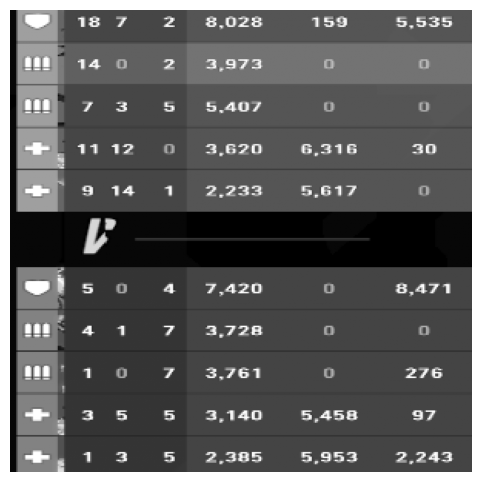

00180702080280015905535011400020397300000000000107030505407000000000002111200036200631600030020914010223305617000001005000407420000000847111040107037280000000000110100070376100000002761203050503140054580009712010305023850595302243


2025-11-04 06:54:38.167237: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [1]:
import pandas as pd
from pandas import CategoricalDtype, DataFrame, read_csv
from math import floor, log10
from pathlib import Path
import tensorflow as tf
from tensorflow.data import Dataset, AUTOTUNE
from tensorflow.image import decode_png, resize
from tensorflow.io import read_file
from matplotlib.pyplot import figure, axis, imshow, show

# ==========================
# 데이터 설정
# ==========================

RESULTS = 'DE', 'DR', 'V'

D_TYPES = {
    'TEAM': 'uint8',
    'ROLE': CategoricalDtype(('T', 'D', 'S')),
    'E': 'uint8',
    'A': 'uint8',
    'D': 'uint8',
    'DMG': 'uint16',
    'H': 'uint16',
    'MIT': 'uint16'
}

ROLE_COUNTS = ('TANK', 1), ('DAMAGE', 2), ('SUPPORT', 2)
TEAMS = 1, 2
NUMERIC_COLS = [col for col in D_TYPES if col not in {'TEAM', 'ROLE'}]

# ==========================
# CSV 로드
# ==========================

df = pd.concat(
    (read_csv(f'R/{result}.csv', index_col=0, dtype=D_TYPES) for result in RESULTS),
    keys=RESULTS, names=('RESULT',)
).dropna()


# ==========================
# 누락된 ROLE 보정 함수
# ==========================

def fill_missing_roles(team_data: DataFrame) -> DataFrame:
    """각 팀의 ROLE 개수를 맞추기 위해 부족한 ROLE을 0으로 채워 넣는다."""
    filled = {col: [] for col in D_TYPES}
    for team in TEAMS:
        team_subset = team_data[team_data['TEAM'] == team]
        for role, expected_count in ROLE_COUNTS:
            missing_count = expected_count - sum(team_subset['ROLE'] == role)
            for _ in range(missing_count):
                filled['TEAM'].append(team)
                filled['ROLE'].append(role)
                for col in NUMERIC_COLS:
                    filled[col].append(0)
    return DataFrame(filled).astype(D_TYPES)


# 누락된 ROLE 채운 데이터 결합
df_full = pd.concat([df, df.groupby(level=(0, 1)).apply(fill_missing_roles)])
df_full.sort_values(['RESULT', 'INDEX', 'TEAM', 'ROLE'], inplace=True)

# ==========================
# 정수형 특징 벡터로 변환
# ==========================

features = DataFrame()
features['TEAM'] = df_full['TEAM'] - 1
features['ROLE'] = df_full['ROLE'].cat.codes.astype('uint8')

for col in NUMERIC_COLS:
    max_digit = floor(log10(df_full[col].max()))
    for d in range(max_digit, -1, -1):
        features[f'{col}{d}'] = (df_full[col] // 10 ** d % 10).astype('uint8')

features_tuple = tuple(features.to_numpy().reshape(-1, 230).T)


# ==========================
# 이미지 전처리 함수
# ==========================

def preprocess_image(path, label):
    """PNG 이미지 파일을 읽고 필요한 부분을 추출 및 리사이즈."""
    image = decode_png(read_file(path), channels=1)[230:930, 530:1370]
    # 필요한 HUD 영역만 선택
    hud_parts = [
        image[:, :40], image[:, 390:420], image[:, 450:480],
        image[:, 500:530], image[:, 570:640], image[:, 670:740], image[:, 770:]
    ]
    cropped = tf.concat(hud_parts, axis=1)
    resized = resize(cropped, (300, 300)) / 255.0
    return resized, label


# ==========================
# Dataset 생성
# ==========================

image_paths = sorted(map(str, Path().rglob('*.png')))
data_count = len(features_tuple[0])

dataset = (
    Dataset.from_tensor_slices((image_paths, features_tuple))
    .map(preprocess_image, num_parallel_calls=AUTOTUNE)
    .shuffle(data_count)
)

train_size = int(data_count * 0.9)
train_ds = dataset.take(train_size).batch(32).prefetch(AUTOTUNE)
val_ds = dataset.skip(train_size).batch(32).prefetch(AUTOTUNE)

# ==========================
# 샘플 시각화
# ==========================

for x_batch, y_batch in train_ds.take(1):
    figure(figsize=(6, 6))
    axis('off')
    imshow(x_batch[0], 'gray')
    show()
    print(*[tensor[0].numpy() for tensor in y_batch], sep='')

In [2]:
from tensorflow.keras.backend import clear_session
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Conv2D, BatchNormalization, ReLU, MaxPool2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import AdamW

clear_session()

# ==========================
# CNN 백본 모델 정의
# ==========================

input_tensor = Input(shape=x_batch.shape[1:])

x = Conv2D(32, (3, 3), padding='same', use_bias=False)(input_tensor)
x = BatchNormalization()(x)
x = ReLU()(x)
x = MaxPool2D()(x)

x = Conv2D(64, (3, 3), padding='same', use_bias=False)(x)
x = BatchNormalization()(x)
x = ReLU()(x)
x = MaxPool2D()(x)

x = Conv2D(128, (3, 3), padding='same', use_bias=False)(x)
x = BatchNormalization()(x)
x = ReLU()(x)
x = MaxPool2D()(x)

x = Conv2D(256, (3, 3), padding='same', use_bias=False)(x)
x = BatchNormalization()(x)
x = ReLU()(x)
x = MaxPool2D()(x)

x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.4)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)

# ==========================
# 다중 출력층 생성
# ==========================

unique_counts = features.nunique()
outputs = [
    Dense(unique_counts[col], activation='softmax', name=f'{col}_{i}')(x)
    for i in range(10) for col in unique_counts.index
]

model = Model(inputs=input_tensor, outputs=outputs)

# ==========================
# 모델 컴파일
# ==========================

len_features_tuple = len(features_tuple)
model.compile(
    optimizer=AdamW(learning_rate=1e-4, weight_decay=1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'] * len_features_tuple
)

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 300, 300,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 300, 300,  │        288 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 300, 300,  │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 300, 300,  │          0 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 150, 150,  │          0 │ re_lu[0][0]       │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 150, 150,  │     18,432 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 150, 150,  │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 150, 150,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 75, 75,    │          0 │ re_lu_1[0][0]     │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 75, 75,    │     73,728 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 75, 75,    │        512 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_2 (ReLU)      │ (None, 75, 75,    │          0 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 37, 37,    │          0 │ re_lu_2[0][0]     │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 37, 37,    │    294,912 │ max_pooling2d_2[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 37, 37,    │      1,024 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_3 (ReLU)      │ (None, 37, 37,    │          0 │ batch_normalizat… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 18, 18,    │          0 │ re_lu_3[0][0]   

 Total params: 43,453,618 (165.76 MB)

 Trainable params: 43,452,658 (165.76 MB)

 Non-trainable params: 960 (3.75 KB)

In [7]:
from tensorflow.keras.callbacks import Callback


# ==========================
# 모델 학습
# ==========================

class AverageAccuracyLogger(Callback):
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        # logs에 accuracy가 여러개로 들어있다면 평균 계산
        acc_keys = [k for k in logs.keys() if 'accuracy' in k and 'val' not in k]
        val_acc_keys = [k for k in logs.keys() if 'val_accuracy' in k]

        if acc_keys:
            logs['accuracy'] = sum([logs[k] for k in acc_keys]) / len(acc_keys)
        if val_acc_keys:
            logs['val_accuracy'] = sum([logs[k] for k in val_acc_keys]) / len(val_acc_keys)

        # 원하는 정보만 출력
        def safe_format(value):
            return f'{value:.4f}' if value is not None else 'N/A'

        print(f'Epoch {epoch + 1}: '
              f'loss={safe_format(logs.get("loss"))}, '
              f'val_loss={safe_format(logs.get("val_loss"))}, '
              f'accuracy={safe_format(logs.get("accuracy"))}, '
              f'val_accuracy={safe_format(logs.get("val_accuracy"))}')


# EarlyStopping 콜백 설정
early_stop = EarlyStopping(  # 검증 손실 기준으로 모니터링
    patience=5,  # 5 epoch 동안 개선 없으면 종료
    verbose=1,
    restore_best_weights=True  # 가장 성능 좋았던 가중치로 복원
)

# 학습
history = model.fit(
    train_ds,
    epochs=32,
    verbose=0,  # 기본 출력 끄기
    validation_data=val_ds,
    callbacks=[AverageAccuracyLogger(), early_stop]
)

Epoch 1: loss=447.7263, val_loss=446.5528, accuracy=0.4361, val_accuracy=N/A
Epoch 2: loss=446.3973, val_loss=445.9690, accuracy=0.4616, val_accuracy=N/A
Epoch 3: loss=445.8119, val_loss=445.3683, accuracy=0.4690, val_accuracy=N/A
Epoch 4: loss=445.5785, val_loss=443.6833, accuracy=0.4552, val_accuracy=N/A
Epoch 5: loss=444.8535, val_loss=444.1414, accuracy=0.4594, val_accuracy=N/A
Epoch 6: loss=444.0537, val_loss=443.4713, accuracy=0.4639, val_accuracy=N/A
Epoch 7: loss=443.4016, val_loss=442.7292, accuracy=0.4621, val_accuracy=N/A
Epoch 8: loss=442.6961, val_loss=441.9954, accuracy=0.4614, val_accuracy=N/A
Epoch 9: loss=441.9066, val_loss=441.0640, accuracy=0.4637, val_accuracy=N/A
Epoch 10: loss=441.0629, val_loss=440.2770, accuracy=0.4638, val_accuracy=N/A
Epoch 11: loss=440.0817, val_loss=439.2741, accuracy=0.4657, val_accuracy=N/A
Epoch 12: loss=438.9902, val_loss=437.8622, accuracy=0.4669, val_accuracy=N/A
Epoch 13: loss=437.7926, val_loss=436.5947, accuracy=0.4691, val_accuracy

이미지 순서를 그대로 유지하자! 정렬은 오히려 혼란을 가중시킨다!